# Spatial Models - Networks

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

%matplotlib inline
plt.style.use('default')

no display found. Using non-interactive Agg backend


In [3]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

In [4]:
# Create graph object and add nodes to it
Graph_obj = nx.Graph()
nodes = df['nodes'].tolist()
Graph_obj.add_nodes_from(nodes)

In [6]:
# Add edges between nodes based on the csv-file
for _, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            Graph_obj.add_edge(source_node, int(col_name))

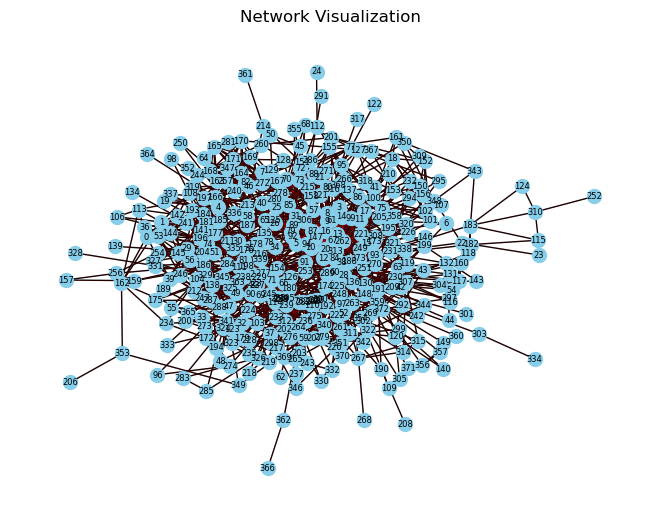

In [7]:
# Relabel the nodes
Graph_obj = nx.convert_node_labels_to_integers(Graph_obj, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_obj)

# draw the nodes and edges
nx.draw(Graph_obj, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_obj, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

In [8]:
# Generate SIR model object
SIR_model = ep.SIRModel(Graph_obj)

# Set parameter values
betas = np.linspace(0.1, 3, 101)
gammas = np.linspace(0.01, 1, 101)
percentage_infected = 0.01
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((len(betas), len(gammas), nr_iterations))
I_store = np.zeros((len(betas), len(gammas), nr_iterations))
R_store = np.zeros((len(betas), len(gammas), nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)

for beta_ix, beta in enumerate(betas):
    for gamma_ix, gamma in enumerate(gammas):
        # (Re)set every node as susceptible
        for node in Graph_obj.nodes():
            SIR_model.status[node] = 0
            
        # Set model configurations
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        SIR_model.set_initial_status(cfg)
        iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
        trends = SIR_model.build_trends(iterations)
        
        # Extract values based on updated structure
        node_counts = trends[0]['trends']['node_count']
        S = node_counts[0]
        I = node_counts[1]
        R = node_counts[2]

        # Store the sums for averages
        S_store[beta_ix, gamma_ix] = S
        I_store[beta_ix, gamma_ix] = I
        R_store[beta_ix, gamma_ix] = R

In [9]:
beta_index = 5
Gamma_index = 5

S_mean_0 = np.mean(S_store[beta_index], axis=0)
I_mean_0 = np.mean(I_store[beta_index], axis=0)
R_mean_0 = np.mean(R_store[beta_index], axis=0)
S_std_0 = np.std(S_store[beta_index], axis=0)
I_std_0 = np.std(I_store[beta_index], axis=0)
R_std_0 = np.std(R_store[beta_index], axis=0)

S_mean_1 = np.mean(S_store[:, Gamma_index], axis=0)
I_mean_1 = np.mean(I_store[:, Gamma_index], axis=0)
R_mean_1 = np.mean(R_store[:, Gamma_index], axis=0)
S_std_1 = np.std(S_store[:, Gamma_index], axis=0)
I_std_1 = np.std(I_store[:, Gamma_index], axis=0)
R_std_1 = np.std(R_store[:, Gamma_index], axis=0)

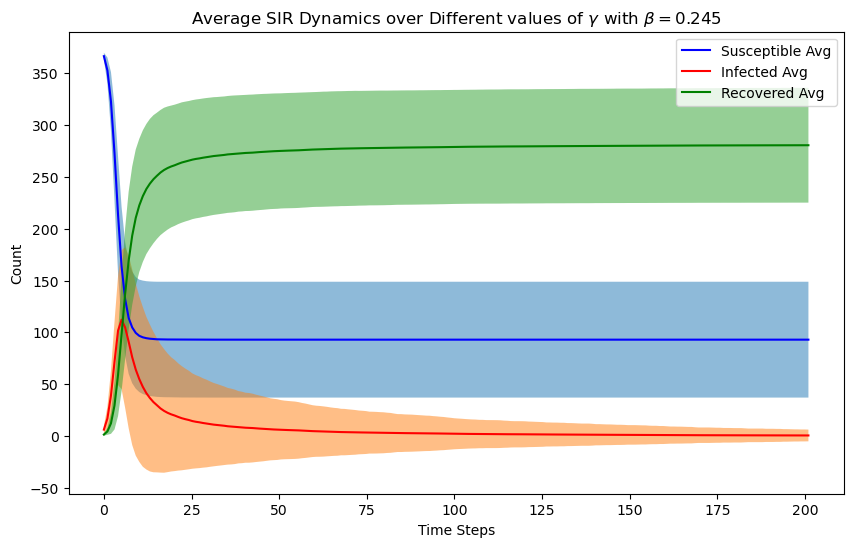

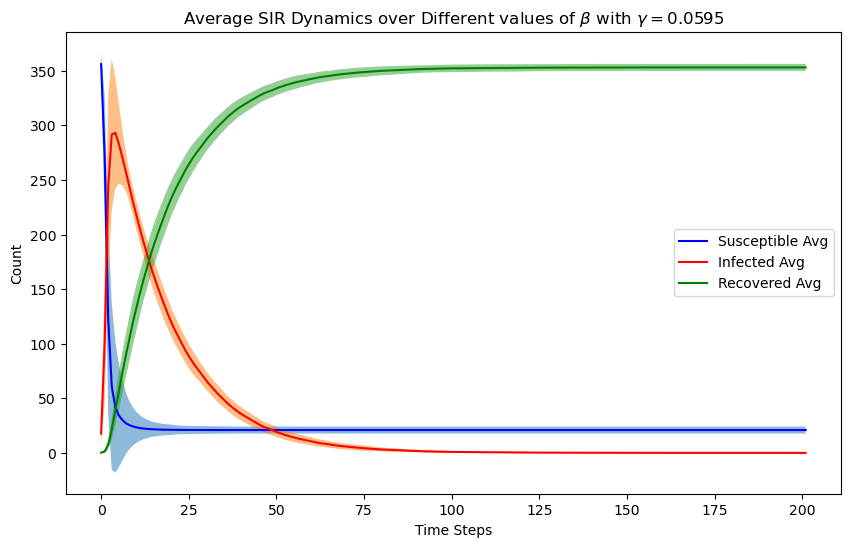

In [10]:
x = np.linspace(0, 201, 200)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_0, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_0 - S_std_0,S_mean_0 + S_std_0, alpha=0.5) 
plt.plot(x, I_mean_0, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_0 - I_std_0,I_mean_0 + I_std_0, alpha=0.5) 
plt.plot(x, R_mean_0, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_0 - R_std_0,R_mean_0 + R_std_0, alpha=0.5) 
plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_1, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_1 - S_std_1,S_mean_1 + S_std_1, alpha=0.5) 
plt.plot(x, I_mean_1, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_1 - I_std_1,I_mean_1 + I_std_1, alpha=0.5) 
plt.plot(x, R_mean_1, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_1 - R_std_1,R_mean_1 + R_std_1, alpha=0.5) 
plt.title(fr"Average SIR Dynamics over Different values of $\beta$ with $\gamma = {gammas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

## Similar networks

In [11]:
def statistic_func(Graph):
    # Pre-allocating return variable
    stats = {}
    
    stats['Nr_of_nodes'] = Graph.number_of_nodes()
    stats['Nr_of_edges'] = Graph.number_of_edges()
        

    degrees = [degree for degree in Graph.degree()]
    stats['Average_degree'] = np.mean(degrees)
    
    
    if degrees:
        stats['average_clustering_coefficient'] = nx.average_clustering(Graph)
        stats['density'] = nx.density(Graph)
        
        degree_centralities = nx.degree_centrality(Graph)
        stats['average_degree_centrality'] = np.mean(list(degree_centralities.values()))
        
        betweenness_centralities = nx.betweenness_centrality(Graph)
        stats['average_betweenness_centrality'] = np.mean(list(betweenness_centralities.values()))
        
        closeness_centrality = nx.closeness_centrality(Graph)
        stats['average_closeness_centrality'] = np.mean(list(closeness_centrality.values()))
        
        if nx.is_connected(Graph):
            stats['diameter'] = nx.diameter(Graph)
            stats['average_shortest_path_length'] = nx.average_shortest_path_length(Graph)
            
        else:
            stats['diameter'] = None
            stats['average_shortest_path_length'] = None
    else:
        stats['average_clustering_coefficient'] = None
        stats['density'] = None
        stats['average_degree_centrality'] = None
        stats['average_betweenness_centrality'] = None
        stats['average_closeness_centrality'] = None

    return stats

### Erdös-Rénji Network


In [12]:
network_size = np.arange(50, 550, 50)
connection_probability = np.arange(0.05, 1.05, 0.05)

results_ER = []

for size in network_size:
    for p in connection_probability:
        Graph_ER = nx.erdos_renyi_graph(size, p)
        stats_ER = statistic_func(Graph_ER)
        results_ER.append(stats_ER)

df_ER = pd.DataFrame(results_ER)

In [33]:
custom_summary = df_ER.groupby(df_ER.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                                                     \
                   mean           std   median   min     max           var   
Nr_of_nodes                                                                  
50               644.65    360.862895    652.5    76    1225  1.302220e+05   
100             2602.50   1469.711948   2627.0   261    4950  2.160053e+06   
150             5872.75   3311.963448   5857.5   535   11175  1.096910e+07   
200            10457.75   5896.129621  10401.0   957   19900  3.476434e+07   
250            16338.55   9232.099285  16384.0  1596   31125  8.523166e+07   
300            23541.65  13274.014533  23551.0  2237   44850  1.761995e+08   
350            32060.70  18072.927789  32096.5  3088   61075  3.266307e+08   
400            41884.35  23644.106000  41773.5  3894   79800  5.590437e+08   
450            53031.60  29871.916333  52968.0  5120  101025  8.923314e+08   
500            65461.60  36874.169017  65465.0  6249  124750  1.359704e+09   

            Average_degree                                     ... diameter  \
                      mean        std      median         min  ...   median   
Nr_of_nodes                                                    ...            
50               25.143000   7.217258   25.300000   13.770000  ...      2.0   
100              50.775000  14.697119   51.020000   27.360000  ...      2.0   
150              76.401667  22.079756   76.300000   40.816667  ...      2.0   
200             102.038750  29.480648  101.755000   54.535000  ...      2.0   
250             127.604200  36.928397  127.786000   68.634000  ...      2.0   
300             153.222167  44.246715  153.253333   82.206667  ...      2.0   
350             178.852000  51.636937  178.954286   96.072857  ...      2.0   
400             204.460875  59.110265  204.183750  109.485000  ...      2.0   
450             230.098000  66.382036  229.956667  123.627778  ...      2.0   
500             255.673200  73.748338  255.680000  137.248000  ...      2.0   

                                average_shortest_path_length            \
             min  max       var                         mean       std   
Nr_of_nodes                                                              
50           1.0  4.0  0.561404                     1.509603  0.398406   
100          1.0  6.0  1.094737                     1.553303  0.469819   
150          1.0  5.0  0.618421                     1.525423  0.412914   
200          1.0  4.0  0.378947                     1.512736  0.382391   
250          1.0  4.0  0.378947                     1.504434  0.359548   
300          1.0  4.0  0.344737                     1.499858  0.349741   
350          1.0  4.0  0.344737                     1.495982  0.340577   
400          1.0  4.0  0.344737                     1.494462  0.337467   
450          1.0  3.0  0.200000                     1.490461  0.327369   
500          1.0  3.0  0.200000                     1.489175  0.323981   

                                                
               median  min       max       var  
Nr_of_nodes                                     
50           1.433469  1.0  2.523265  0.158727  
100          1.469293  1.0  2.950505  0.220730  
150          1.475839  1.0  2.751499  0.170498  
200          1.477337  1.0  2.592714  0.146223  
250          1.473606  1.0  2.444916  0.129275  
300          1.474894  1.0  2.402185  0.122318  
350          1.474474  1.0  2.341711  0.115993  
400          1.476523  1.0  2.320890  0.113884  
450          1.475694  1.0  2.246998  0.107171  
500          1.475230  1.0  2.222758  0.104964  

[10 rows x 54 columns]

In [14]:
ps = np.arange(0.018, 0.02, 0.001)
for p in ps:
    Graph_ER = nx.erdos_renyi_graph(374, p)
    stats_ER = statistic_func(Graph_ER)
    print(p, stats_ER['Nr_of_edges'])

0.018 1325
0.019 1282
0.02 1470


In [15]:
# Generate Barabasi-Albert graph similar to the given model
Graph_ER = nx.erdos_renyi_graph(374, 0.019)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_ER)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

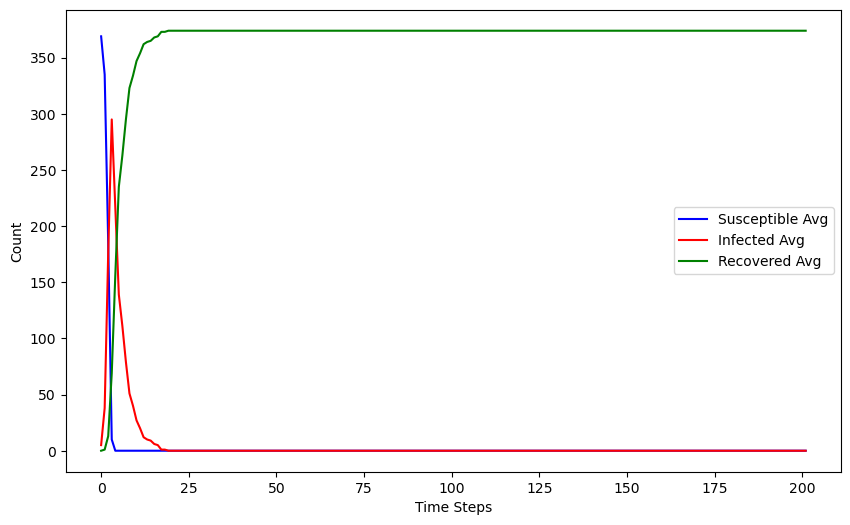

In [16]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Watts-Stograz network

In [17]:
nodes = np.arange(50, 550, 50) 
k_values = np.arange(1,10,1)
p_values = np.linspace(0.1, 1, 10)

results_WS = []

for size in nodes:
    for k in k_values:
        for p in p_values:
            Graph_WS = nx.watts_strogatz_graph(size, k, p)
            stats_WR = statistic_func(Graph_WS)
            results_WS.append(stats_WR)
            
df_WS = pd.DataFrame(results_WS)

c:\Users\kevin\anaconda3\envs\ABM\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kevin\anaconda3\envs\ABM\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
custom_summary = df_WS.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                                                \
                   mean         std  median  min   max            var   
Nr_of_nodes                                                             
0                   0.0    0.000000     0.0    0     0       0.000000   
50                125.0   56.254395   125.0   50   200    3164.556962   
100               250.0  112.508790   250.0  100   400   12658.227848   
150               375.0  168.763185   375.0  150   600   28481.012658   
200               500.0  225.017580   500.0  200   800   50632.911392   
250               625.0  281.271975   625.0  250  1000   79113.924051   
300               750.0  337.526370   750.0  300  1200  113924.050633   
350               875.0  393.780765   875.0  350  1400  155063.291139   
400              1000.0  450.035160  1000.0  400  1600  202531.645570   
450              1125.0  506.289555  1125.0  450  1800  256329.113924   
500              1250.0  562.543950  1250.0  500  2000  316455.696203   

            Average_degree                            ... diameter       \
                      mean       std  median     min  ...   median  min   
Nr_of_nodes                                           ...                 
0                      NaN       NaN     NaN     NaN  ...      NaN  NaN   
50                   14.75  1.125088   14.75   13.25  ...      5.0  3.0   
100                  27.25  1.125088   27.25   25.75  ...      5.0  4.0   
150                  39.75  1.125088   39.75   38.25  ...      6.0  4.0   
200                  52.25  1.125088   52.25   50.75  ...      6.5  4.0   
250                  64.75  1.125088   64.75   63.25  ...      6.0  4.0   
300                  77.25  1.125088   77.25   75.75  ...      7.0  5.0   
350                  89.75  1.125088   89.75   88.25  ...      6.0  5.0   
400                 102.25  1.125088  102.25  100.75  ...      6.5  5.0   
450                 114.75  1.125088  114.75  113.25  ...      7.0  5.0   
500                 127.25  1.125088  127.25  125.75  ...      7.0  5.0   

                               average_shortest_path_length            \
               max         var                         mean       std   
Nr_of_nodes                                                             
0              NaN         NaN                          NaN       NaN   
50            41.0   70.377658                     3.897894  2.983408   
100           49.0   94.115332                     4.165536  3.323955   
150           54.0  138.569151                     5.049042  4.249782   
200          101.0  358.398865                     6.314868  6.620935   
250          104.0  382.668476                     5.910420  6.951712   
300           95.0  317.728490                     6.116938  6.500111   
350          102.0  196.083554                     4.902093  5.243595   
400           88.0  256.956101                     5.631608  6.077399   
450           87.0  249.276786                     5.572636  5.541534   
500           82.0  207.665643                     5.442901  5.350437   

                                                       
               median       min        max        var  
Nr_of_nodes                                            
0                 NaN       NaN        NaN        NaN  
50           2.698776  2.035102  15.253061   8.900722  
100          2.979596  2.408889  17.321818  11.048678  
150          3.407114  2.606264  19.771365  18.060649  
200          3.729020  2.752060  35.668141  43.836783  
250          3.650120  2.861655  40.675663  48.326302  
300          3.903478  2.957324  35.999866  42.251442  
350          3.716038  3.042964  40.663512  27.495288  
400          3.898277  3.109035  32.326930  36.934783  
450          3.952987  3.166414  31.241712  30.708601  
500          4.048016  3.226838  30.918196  28.627181  

[11 rows x 54 columns]

In [19]:
display(df_WS)

,Nr_of_nodes,Nr_of_edges,Average_degree,average_clustering_coefficient,density,average_degree_centrality,average_betweenness_centrality,average_closeness_centrality,diameter,average_shortest_path_length
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
895,500,2000,128.75,0.049853,0.016032,0.016032,0.004574,0.305500,5.0,3.277956
896,500,2000,128.75,0.023948,0.016032,0.016032,0.004500,0.309013,5.0,3.240866
897,500,2000,128.75,0.016652,0.016032,0.016032,0.004487,0.309597,5.0,3.234717
898,500,2000,128.75,0.014798,0.016032,0.016032,0.004476,0.310132,5.0,3.229066


In [20]:
# Generate Barabasi-Albert graph similar to the given model
Graph_WS = nx.watts_strogatz_graph(374, 4, 0.9)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_WS)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 100

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

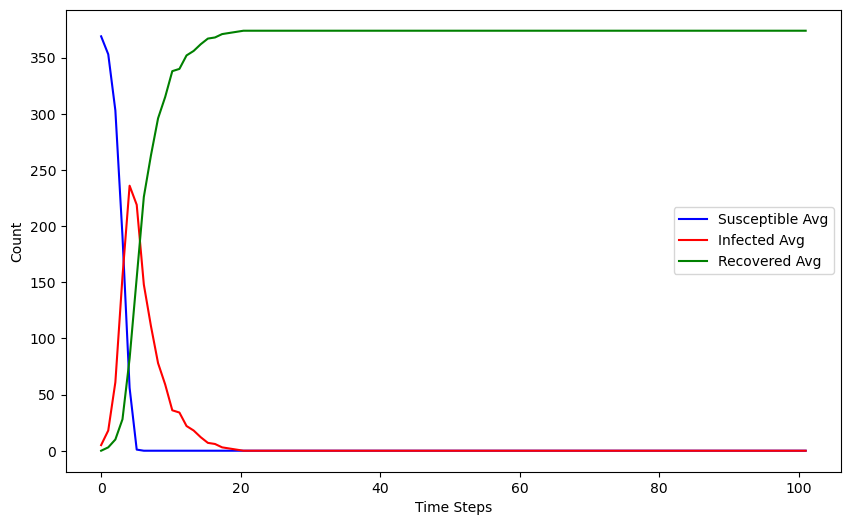

In [21]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Barabási-Albert network

In [22]:
nodes = np.arange(50,550,50)
m_values = np.arange(1,11,10)

results_BA = []

for size in nodes:
    for m in m_values:
        Graph_BA = nx.barabasi_albert_graph(size, m)
        stats_BA = statistic_func(Graph_BA)
        results_BA.append(stats_BA)
        
df_BA = pd.DataFrame(results_BA)

In [23]:
custom_summary = df_BA.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                          Average_degree      \
                   mean std median  min  max var           mean std   
Nr_of_nodes                                                           
50                 49.0 NaN   49.0   49   49 NaN      13.230000 NaN   
100                99.0 NaN   99.0   99   99 NaN      25.740000 NaN   
150               149.0 NaN  149.0  149  149 NaN      38.243333 NaN   
200               199.0 NaN  199.0  199  199 NaN      50.745000 NaN   
250               249.0 NaN  249.0  249  249 NaN      63.246000 NaN   
300               299.0 NaN  299.0  299  299 NaN      75.746667 NaN   
350               349.0 NaN  349.0  349  349 NaN      88.247143 NaN   
400               399.0 NaN  399.0  399  399 NaN     100.747500 NaN   
450               449.0 NaN  449.0  449  449 NaN     113.247778 NaN   
500               499.0 NaN  499.0  499  499 NaN     125.748000 NaN   

                                     ... diameter              \
                 median         min  ...   median min max var   
Nr_of_nodes                          ...                        
50            13.230000   13.230000  ...      9.0   9   9 NaN   
100           25.740000   25.740000  ...     13.0  13  13 NaN   
150           38.243333   38.243333  ...      9.0   9   9 NaN   
200           50.745000   50.745000  ...     15.0  15  15 NaN   
250           63.246000   63.246000  ...     12.0  12  12 NaN   
300           75.746667   75.746667  ...     13.0  13  13 NaN   
350           88.247143   88.247143  ...     14.0  14  14 NaN   
400          100.747500  100.747500  ...     15.0  15  15 NaN   
450          113.247778  113.247778  ...     12.0  12  12 NaN   
500          125.748000  125.748000  ...     14.0  14  14 NaN   

            average_shortest_path_length                                        
                                    mean std    median       min       max var  
Nr_of_nodes                                                                     
50                              4.335510 NaN  4.335510  4.335510  4.335510 NaN  
100                             5.238990 NaN  5.238990  5.238990  5.238990 NaN  
150                             4.289575 NaN  4.289575  4.289575  4.289575 NaN  
200                             5.763015 NaN  5.763015  5.763015  5.763015 NaN  
250                             5.377703 NaN  5.377703  5.377703  5.377703 NaN  
300                             6.072419 NaN  6.072419  6.072419  6.072419 NaN  
350                             5.590143 NaN  5.590143  5.590143  5.590143 NaN  
400                             6.261140 NaN  6.261140  6.261140  6.261140 NaN  
450                             5.109765 NaN  5.109765  5.109765  5.109765 NaN  
500                             6.066725 NaN  6.066725  6.066725  6.066725 NaN  

[10 rows x 54 columns]

## Barabási-Albert SIR spread

In [30]:
# Generate Barabasi-Albert graph similar to the given model
Graph_BA = nx.barabasi_albert_graph(374, 4)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_BA)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

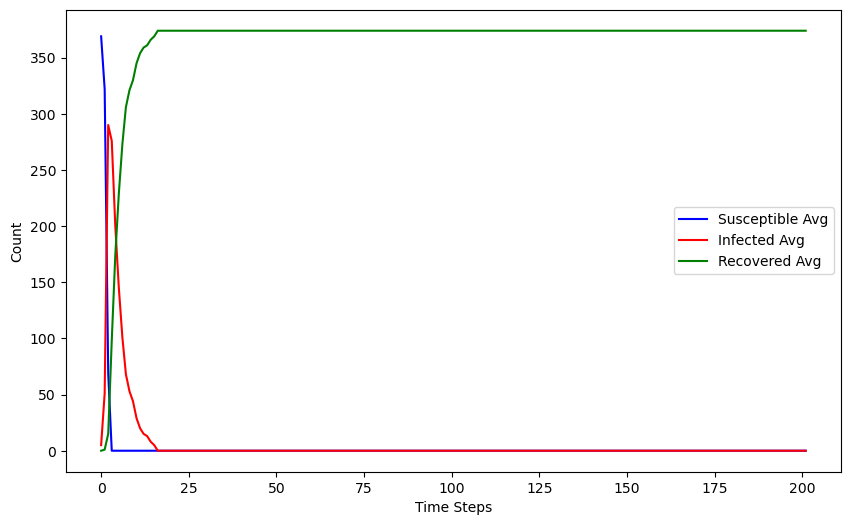

In [31]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Dynamic Vaccination Campaign

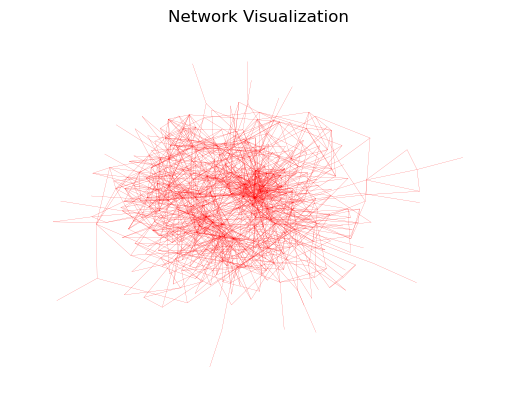

In [36]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

# Create graph object and add nodes to it
Graph_obj = nx.Graph()
nodes = df['nodes'].tolist()
Graph_obj.add_nodes_from(nodes)

# Add edges between nodes based on the csv-file
for _, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            Graph_obj.add_edge(source_node, int(col_name))
            

# Relabel the nodes
Graph_obj = nx.convert_node_labels_to_integers(Graph_obj, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_obj)

# draw the nodes and edges
nx.draw(Graph_obj, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_obj, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

In [ ]:
# Generate SIR model object
SIR_model = ep.SIRModel(Graph_obj)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 100

# Pre-allocate variables.
S_store = np.zeros(nr_iterations)
I_store = np.zeros(nr_iterations)
R_store = np.zeros(nr_iterations)

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected) 


# (Re)set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()
